In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Load data

# Companies
companies = ['NFLX', 'FB', 'AMZN', 'TSLA', 'GOOG', 'AAPL']
company = companies[0]

days_for_validation = 300

days_for_test = 100

# define the time as "yyyy-mm-dd"
start_time = dt.datetime(2012, 1, 1)
# last day for full training - yesterday
end_time_full = dt.datetime.now() - dt.timedelta(days=1)
# last day for preliminary training - yesterday minus days_for_test ago
end_time_preliminary = dt.datetime.now() - dt.timedelta(days=1) - dt.timedelta(days=days_for_test)

data_full = web.DataReader(company, 'yahoo', start_time, end_time_full)
data_preliminary_train = web.DataReader(company, 'yahoo', start_time, end_time_preliminary)
data_full.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-06-10,490.209991,482.140015,487.170013,487.269989,4382900.0,487.269989
2021-06-11,491.410004,487.779999,490.000000,488.769989,3121400.0,488.769989
2021-06-14,503.500000,486.910004,489.679993,499.890015,4400200.0,499.890015
2021-06-15,501.230011,490.399994,501.230011,491.899994,3104100.0,491.899994
2021-06-16,496.459991,486.279999,495.000000,492.410004,3527700.0,492.410004


In [3]:
data_preliminary_train.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-02,556.989990,546.020020,553.340027,547.820007,3042200.0,547.820007
2021-03-03,548.010010,517.809998,545.929993,520.700012,5362400.0,520.700012
2021-03-04,531.500000,507.679993,521.500000,511.290009,5034800.0,511.290009
2021-03-05,517.760010,498.790009,511.980011,516.390015,5070000.0,516.390015
2021-03-08,518.840027,492.850006,514.460022,493.329987,3981800.0,493.329987


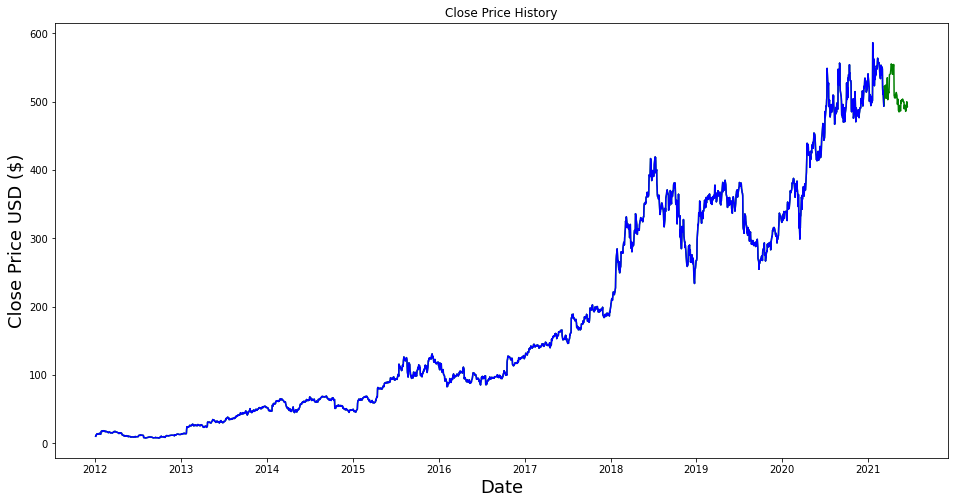

In [4]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data_full['Adj Close'], color='green')
plt.plot(data_preliminary_train['Adj Close'], color='blue')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
data_preliminary_train['Adj Close']
print('Shape of Dataframe column:', data_preliminary_train['Adj Close'].shape)

Shape of Dataframe column: (2309,)


In [6]:
data_preliminary_train['Adj Close'].values.shape

(2309,)

In [7]:
# Convert the Series to a Numpy array and transform to column
data_close = data_preliminary_train['Adj Close'].values.reshape(-1, 1)
print('Shape of column:', data_close.shape)

Shape of column: (2309, 1)


In [8]:
# Scale the Train Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_close)
scaled_data

array([[0.00455243],
       [0.0065793 ],
       [0.0062954 ],
       ...,
       [0.8703025 ],
       [0.87911606],
       [0.83926493]])

In [9]:
# Prepare the Training Dataset

# Number of days for prediction each next day during training
days_for_prediction_on_train = 50

x_train = []
y_train = []

# We use days_for_prediction_on_train (days) to predict 1 next day
for x in range(days_for_prediction_on_train, len(scaled_data)):
    x_train.append(scaled_data[x - days_for_prediction_on_train : x, 0])
    y_train.append(scaled_data[x, 0])

# x_train is the list with ndarrays inside
# and each ndarray consists of days_for_prediction_on_train values of price
x_train

[array([0.00455243, 0.0065793 , 0.0062954 , 0.00802107, 0.01095646,
        0.01037629, 0.00946778, 0.00946778, 0.01001832, 0.01010226,
        0.01104533, 0.01225997, 0.01146502, 0.00991463, 0.00959616,
        0.01018126, 0.01535829, 0.01727901, 0.01768389, 0.01639271,
        0.01707657, 0.01733085, 0.01793076, 0.01862696, 0.01828874,
        0.01733085, 0.01753823, 0.01731357, 0.01592364, 0.01710125,
        0.01685191, 0.01681488, 0.01680006, 0.01570146, 0.01446706,
        0.01461272, 0.01428684, 0.0137289 , 0.01469419, 0.01405478,
        0.01455347, 0.01513364, 0.01407453, 0.01316602, 0.01268707,
        0.01339808, 0.01365977, 0.01293642, 0.01297345, 0.01270188]),
 array([0.0065793 , 0.0062954 , 0.00802107, 0.01095646, 0.01037629,
        0.00946778, 0.00946778, 0.01001832, 0.01010226, 0.01104533,
        0.01225997, 0.01146502, 0.00991463, 0.00959616, 0.01018126,
        0.01535829, 0.01727901, 0.01768389, 0.01639271, 0.01707657,
        0.01733085, 0.01793076, 0.01862696, 0.

In [10]:
# Convert the list to ndarray
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2259, 50)

In [11]:
# Do reshape in order to add dimension for batch
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2259, 50, 1)

In [12]:
# Build the Model
model = Sequential()

model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
#model.add(LSTM(units=60, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2))
# Prediction of the next price (closing value)
model.add(Dense(units=64))
model.add(Dense(units=32))
model.add(Dense(units=1))

сheckpoint = ModelCheckpoint(f'best_model_{company}.h5', monitor='val_loss', save_best_only=True, verbose=1)
epochs=30
batch_size=64

# Train the Model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train[:(len(x_train) - days_for_validation)], y_train[:(len(x_train) - days_for_validation)], epochs=epochs,
          batch_size=batch_size, validation_data=(x_train[(len(x_train) - days_for_validation):],
          y_train[(len(x_train) - days_for_validation):]), shuffle=False, callbacks=[сheckpoint])

Epoch 1/30
31/31 [==============================] - 10s 30ms/step - loss: 0.0023 - val_loss: 0.0112

Epoch 00001: val_loss improved from inf to 0.01119, saving model to best_model_NFLX.h5
Epoch 2/30
31/31 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0039

Epoch 00002: val_loss improved from 0.01119 to 0.00391, saving model to best_model_NFLX.h5
Epoch 3/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0041

Epoch 00003: val_loss did not improve from 0.00391
Epoch 4/30
31/31 [==============================] - 0s 7ms/step - loss: 9.9335e-04 - val_loss: 0.0022

Epoch 00004: val_loss improved from 0.00391 to 0.00221, saving model to best_model_NFLX.h5
Epoch 5/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0016

Epoch 00005: val_loss improved from 0.00221 to 0.00158, saving model to best_model_NFLX.h5
Epoch 6/30
31/31 [==============================] - 0s 7ms/step - loss: 9.7144e-04 - val

In [13]:
''' Test the Model Accuracy on Unseen Existing Data '''

test_data_and_part_of_train = data_full['Adj Close'][len(data_full) - days_for_test - days_for_prediction_on_train:].values
test_data_and_part_of_train = test_data_and_part_of_train.reshape(-1,  1)
scaled_data_test = scaler.transform(test_data_and_part_of_train)

x_test = []
y_test = []

for x in range(days_for_prediction_on_train, len(scaled_data_test)):
    x_test.append(scaled_data_test[x - days_for_prediction_on_train : x, 0])
    y_test.append(test_data_and_part_of_train[x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape

(100, 50, 1)

In [14]:
# Make Predictions on Test Data
model = load_model(f'best_model_{company}.h5')
predicted_test_prices_scaled = model.predict(x_test)
predicted_test_prices = scaler.inverse_transform(predicted_test_prices_scaled)

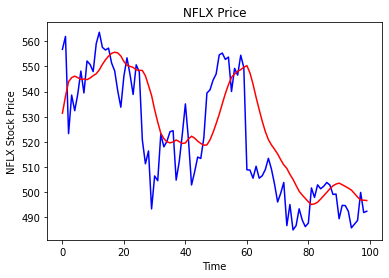

In [15]:
# Plot the Test Predictions
plt.plot(y_test, color='blue', label=f'Actual {company} price')
plt.plot(predicted_test_prices, color='red', label=f'Predicted {company} price')
plt.title(f'{company} Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Stock Price')
plt.show()

In [16]:
# Evaluate mean squared error on test data
y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1, 1))
rmse = mean_squared_error(y_test_scaled, predicted_test_prices_scaled)
print('Mean Squared Error on Test Dataset =', rmse)

Mean Squared Error on Test Dataset = 0.26899803116487936


In [17]:
# Predict Today
data_for_current_prediction = data_full['Adj Close'][len(data_full) - days_for_prediction_on_train: len(data_full) + 1].values
data_for_current_prediction = data_for_current_prediction.reshape(-1,  1)
data_for_current_prediction_scaled = scaler.transform(data_for_current_prediction)

data_for_current_prediction_scaled.shape

(50, 1)

In [18]:
data_for_current_prediction_scaled = np.reshape(data_for_current_prediction_scaled,
                                                (1, data_for_current_prediction_scaled.shape[0], 1))
data_for_current_prediction_scaled.shape

(1, 50, 1)

In [19]:
# Make Predictions on Test Data
predicted_price_today = model.predict(data_for_current_prediction_scaled)
predicted_price_today = scaler.inverse_transform(predicted_price_today)

print(f'Prediction ({company}) for now: {predicted_price_today}')

Prediction (NFLX) for now: [[489.28912]]
